In [42]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os


In [43]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1000):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [44]:
process_type='inter'

species='mouse'
SRP_name='aggregates'
resolution='10kbp_raw'

In [45]:
base_folder='/grid/gillis/data_norepl/lohia'

In [71]:
with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/1kbp_raw/max/contact_top1/hic_gene_inter_none_by_allbins_top1.h5', 'r') as hf:
    gene_list = hf['gene_list'][:]
    bins_bed = hf['bins_bed'][:]

In [72]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [1000]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [73]:
cat_list_genes = marker_table.index.tolist()

In [74]:
    input_path=f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b {base_folder}/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  {base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'{base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'{base_folder}/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'{base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [75]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [230]:
import random
o_list = list(range(1,100))
all_marker_1 = set(random.sample(o_list, 50))

all_marker_2 = set(o_list) - set(all_marker_1)

all_marker_1 = list(all_marker_1)
all_marker_2 = list(all_marker_2)

In [367]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            df2_list.append(m_tmp[m_tmp['%recurrence'] >0.80])
            df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [340]:
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [179]:
marker_list[marker_list['%recurrence']>0.8]

group cell_type  rank      gene  recurrence     auroc  \
0       GABAergic     Lamp5     1  Cacna2d1           7  0.917386   
1       GABAergic     Lamp5     2      Nfib           7  0.912118   
2       GABAergic     Lamp5     3     Fgf13           7  0.901015   
3       GABAergic     Lamp5     4     Lamp5           7  0.888027   
4       GABAergic     Lamp5     5     Nyap2           7  0.880791   
...           ...       ...   ...       ...         ...       ...   
458132      Other     Oligo   100     Sytl2           6  0.705172   
458133      Other     Oligo   101    Plxnb3           6  0.701251   
458134      Other     Oligo   102     Tnni1           6  0.672303   
458135      Other     Oligo   103      Insc           6  0.659766   
458136      Other     Oligo   104    Spock3           6  0.630340   

        fold_change  fold_change_detection   expression  precision  ...  \
0         10.109405               2.929707   675.305674   0.426564  ...   
1          5.528881               2.194696  1005.675270   0.358736  ...   
2          6.533759               1.556656  1381.346789   0.291647  ...   
3         51.467129               8.456450   521.944914   0.677288  ...   
4          8.377744               2.048543   698.804404   0.346876  ...   
...             ...                    ...          ...        ...  ...   
458132    17.214760              10.021298   196.789311   0.793296  ...   
458133    60.841502              58.768144   155.371286   0.911271  ...   
458134   123.066919             181.548829   134.167828   0.993745  ...   
458135    50.010678              53.658448   138.052988   0.864107  ...   
458136    10.945119               3.122417     0.000000   0.712950  ...   

        population_size  n_datasets   scSS  snSS scCv2 snCv2 snCv3M  scCv3  \
0           2057.142857           7   True  True  True  True   True   True   
1           2057.142857           7   True  True  True  True   True   True   
2           2057.142857           7   True  True  True  True   True   True   
3           2057.142857           7   True  True  True  True   True   True   
4           2057.142857           7   True  True  True  True   True   True   
...                 ...         ...    ...   ...   ...   ...    ...    ...   
458132      3863.571429           7  False  True  True  True   True   True   
458133      3863.571429           7  False  True  True  True   True   True   
458134      3863.571429           7  False  True  True  True   True   True   
458135      3863.571429           7  False  True  True  True   True   True   
458136      3863.571429           7  False  True  True  True   True   True   

       snCv3Z  %recurrence  
0        True     1.000000  
1        True     1.000000  
2        True     1.000000  
3        True     1.000000  
4        True     1.000000  
...       ...          ...  
458132   True     0.857143  
458133   True     0.857143  
458134   True     0.857143  
458135   True     0.857143  
458136   True     0.857143  

[931 rows x 21 columns]

In [368]:
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()

In [258]:
marker_list

classt    group       cell_type Ensembl_gene_identifier
138      GABAergic    Pvalb   Pvalb Vipr2_1      ENSMUSG00000026235
136  Glutamatergic  L5/6 NP       L5/6 NP_3      ENSMUSG00000052560
146      GABAergic    Lamp5   Lamp5 Egln3_1      ENSMUSG00000001988
55       GABAergic    Pvalb  Pvalb Il1rapl2      ENSMUSG00000058897
126  Glutamatergic    L5 IT         L5 IT_4      ENSMUSG00000045573
..             ...      ...             ...                     ...
116      GABAergic    Pvalb   Pvalb Vipr2_2      ENSMUSG00000021991
84       GABAergic    Lamp5   Lamp5 Egln3_2      ENSMUSG00000021508
48   Glutamatergic    L5 IT         L5 IT_1      ENSMUSG00000070695
134  Glutamatergic    L5 IT         L5 IT_1      ENSMUSG00000044365
132      GABAergic      Vip  Vip Serpinf1_2      ENSMUSG00000042401

[166 rows x 4 columns]

In [536]:
if marker_level == 'cluster':

    marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']], how='left')
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()

    
if marker_level == 'class':
    #marker_list.rename(columns = {'group':'classt'}, inplace = True)
    #marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['group'] = marker_list['cell_type'].tolist()
    marker_list['classt'] = marker_list['cell_type'].tolist()
    #marker_list['cell_type'] = marker_list['Ensembl_gene_identifier'].tolist()

In [377]:
marker_list['classt'] = [y if y=='Non-Neuronal' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
#market_list = marker_list.dropna(subset=['classt'])

In [407]:
pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv').drop_duplicates(['cell_type'])



group   cell_type  rank      gene  recurrence     auroc  \
0          GABAergic       Lamp5     1  Cacna2d1           7  0.918146   
1000       GABAergic       Pvalb     1     Pvalb           7  0.908463   
2000       GABAergic        Sncg     1      Cnr1           7  0.968239   
3000       GABAergic         Sst     1       Sst           7  0.951460   
4000       GABAergic         Vip     1       Vip           7  0.922197   
5000   Glutamatergic     L2/3 IT     1   Rasgrf2           7  0.874715   
6000   Glutamatergic       L5 ET     1    Gm2164           7  0.932605   
7000   Glutamatergic       L5 IT     1   Slc24a3           7  0.815052   
8000   Glutamatergic     L5/6 NP     1     Tshz2           7  0.988350   
9000   Glutamatergic       L6 CT     1     Foxp2           7  0.942359   
10000  Glutamatergic       L6 IT     1   Galnt14           7  0.844825   
11000  Glutamatergic  L6 IT Car3     1     Synpr           4  0.985914   
12000  Glutamatergic         L6b     1    Inpp4b           7  0.930382   

       fold_change  fold_change_detection   expression  precision    recall  \
0        10.042314               2.918454   679.620180   0.421814  0.920170   
1000     51.890543              10.259585   548.793187   0.730363  0.835400   
2000     10.029039               1.791292  3250.949738   0.062676  0.977336   
3000    131.622843               6.243620  2996.160064   0.674665  0.920548   
4000     44.318331               5.790294  5766.137065   0.632019  0.881093   
5000      8.544493               3.443147   250.674531   0.475482  0.825780   
6000     17.273722               6.952110   230.624723   0.159251  0.912025   
7000      6.194582               2.648420   230.492660   0.584156  0.788087   
8000    166.750153              11.835138  2145.051266   0.362030  0.979409   
9000     23.198230               5.332981   447.828075   0.600898  0.913473   
10000     6.796150               3.412028   254.188308   0.250478  0.815586   
11000    39.684105               3.652890  1800.695611   0.015798  0.983788   
12000    25.615801               5.404430   600.009493   0.181291  0.907925   

       population_size  n_datasets  scSS  snSS  scCv2  snCv2 snCv3M  scCv3  \
0          2037.857143           7  True  True   True   True   True   True   
1000       2605.428571           7  True  True   True   True   True   True   
2000        397.571429           7  True  True   True   True   True   True   
3000       2647.428571           7  True  True   True   True   True   True   
4000       2499.857143           7  True  True   True   True   True   True   
5000      12214.285714           7  True  True   True   True   True   True   
6000       1374.285714           7  True  True   True   True   True   True   
7000      17987.000000           7  True  True   True   True   True   True   
8000       2103.000000           7  True  True   True   True   True   True   
9000      10768.285714           7  True  True   True   True   True   True   
10000      4230.571429           7  True  True   True   True   True   True   
11000       253.250000           4  True   NaN   True   True    NaN   True   
12000      1018.571429           7  True  True   True   True   True   True   

      snCv3Z  
0       True  
1000    True  
2000    True  
3000    True  
4000    True  
5000    True  
6000    True  
7000    True  
8000    True  
9000    True  
10000   True  
11000    NaN  
12000   True

In [399]:
pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1).drop_duplicates(['cell_type'])



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


group   cell_type  rank      gene  recurrence     auroc  \
0           GABAergic       Lamp5     1  Cacna2d1           7  0.917386   
24107       GABAergic       Pvalb     1     Pvalb           7  0.908454   
48214       GABAergic        Sncg     1      Cnr1           7  0.974766   
72321       GABAergic         Sst     1       Sst           7  0.938717   
96428       GABAergic   Sst Chodl     1      Nos1           7  0.995777   
120535      GABAergic         Vip     1       Vip           7  0.925423   
144642  Glutamatergic     L2/3 IT     1   Rasgrf2           7  0.881332   
168749  Glutamatergic     L4/5 IT     1      Rorb           7  0.903344   
192856  Glutamatergic       L5 IT     1  Il1rapl2           7  0.793787   
216963  Glutamatergic       L5 PT     1    Gm2164           7  0.937994   
241070  Glutamatergic     L5/6 NP     1     Tshz2           7  0.997039   
265177  Glutamatergic       L6 CT     1     Foxp2           7  0.941955   
289284  Glutamatergic       L6 IT     1   Galnt14           7  0.850208   
313391  Glutamatergic  L6 IT Car3     1     Synpr           6  0.961941   
337498  Glutamatergic         L6b     1      Ctgf           7  0.916112   
361605          Other       Astro     1    Slc1a2           6  0.995769   
385712          Other        Endo     1       Bsg           6  0.987196   
409819          Other       Meis2     1     Nrxn3           1  0.996478   
433926          Other   Micro-PVM     1    Cx3cr1           6  0.965773   
458033          Other       Oligo     1    Tmeff2           6  0.944731   
482140          Other        Peri     1       Vtn           4  0.982834   
506247          Other         SMC     1      Mylk           4  0.984436   
530354          Other        VLMC     1     Cped1           3  0.916987   

        fold_change  fold_change_detection    expression  precision    recall  \
0         10.109405               2.929707    675.305674   0.426564  0.919395   
24107     50.202707              10.291493    548.272709   0.730663  0.835562   
48214     10.748725               1.822091   3350.683647   0.075947  0.983333   
72321     23.621281               5.694936   2877.268984   0.640869  0.916721   
96428    113.720290               7.990631   2139.705939   0.117712  0.993798   
120535    31.937096               5.746633   5782.090319   0.622032  0.893226   
144642     8.259328               3.355942    260.379911   0.444603  0.839834   
168749    15.084335               3.548553    442.440711   0.549722  0.875661   
192856     9.636183               3.038109    439.170965   0.337095  0.734869   
216963    17.488513               7.010796    233.357181   0.159184  0.919884   
241070   177.886930              12.104955   2172.486959   0.365034  0.995664   
265177    22.168319               5.179712    449.193201   0.595106  0.914056   
289284     6.714156               3.247650    279.842412   0.174384  0.830742   
313391    34.402575               3.726917   1382.993836   0.011024  0.944400   
337498    91.902466              16.276066    658.077885   0.360320  0.844480   
361605    79.327970               3.925241   6011.876920   0.627385  0.995734   
385712    46.299057               2.047367  12302.381877   0.131569  0.984376   
409819    59.571560               1.859553  27371.516407   0.003604  1.000000   
433926   323.765040              34.180356   2092.673914   0.713247  0.934731   
458033   143.085980              11.943710   2622.750192   0.833646  0.904242   
482140   109.301740              25.890554   5954.286808   0.381873  0.977192   
506247    40.234937              12.242725   1111.723420   0.176158  1.000000   
530354    45.429227              11.528995   1572.348942   0.238012  0.874858   

        population_size  n_datasets   scSS  snSS scCv2  snCv2  snCv3M scCv3  \
0           2057.142857           7   True  True  True   True    True  True   
24107       2562.428571           7   True  True  True   True    True  True   
48214        442.857143          

In [427]:
pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


group cell_type   rank      gene  recurrence     auroc  \
0       GABAergic     Lamp5      1  Cacna2d1           7  0.917386   
1       GABAergic     Lamp5      2      Nfib           7  0.912118   
2       GABAergic     Lamp5      3     Fgf13           7  0.901015   
3       GABAergic     Lamp5      4     Lamp5           7  0.888027   
4       GABAergic     Lamp5      5     Nyap2           7  0.880791   
...           ...       ...    ...       ...         ...       ...   
554456      Other      VLMC  24103     Ncam1           0  0.225582   
554457      Other      VLMC  24104     Mdga2           0  0.218591   
554458      Other      VLMC  24105     Lrp1b           0  0.211522   
554459      Other      VLMC  24106        Qk           0  0.203795   
554460      Other      VLMC  24107     Pcdh9           0  0.171131   

        fold_change  fold_change_detection   expression  precision    recall  \
0         10.109405               2.929707   675.305674   0.426564  0.919395   
1          5.528881               2.194696  1005.675270   0.358736  0.966526   
2          6.533759               1.556656  1381.346789   0.291647  0.920615   
3         51.467129               8.456450   521.944914   0.677288  0.800378   
4          8.377744               2.048543   698.804404   0.346876  0.887232   
...             ...                    ...          ...        ...       ...   
554456     0.022009               0.124623     0.000000   0.027392  0.166870   
554457     0.019794               0.045153     0.000000   0.006513  0.142880   
554458     0.009624               0.020770     0.000000   0.007108  0.148896   
554459     0.230734               0.828014   369.494096   0.046206  0.728007   
554460     0.012229               0.060684     0.000000   0.010692  0.269239   

        population_size  n_datasets   scSS  snSS  scCv2  snCv2  snCv3M scCv3  \
0           2057.142857           7   True  True   True   True    True  True   
1           2057.142857           7   True  True   True   True    True  True   
2           2057.142857           7   True  True   True   True    True  True   
3           2057.142857           7   True  True   True   True    True  True   
4           2057.142857           7   True  True   True   True    True  True   
...                 ...         ...    ...   ...    ...    ...     ...   ...   
554456       473.000000           5  False   NaN  False  False   False   NaN   
554457       473.000000           5  False   NaN  False  False   False   NaN   
554458       473.000000           5  False   NaN  False  False   False   NaN   
554459       473.000000           5  False   NaN  False  False   False   NaN   
554460       473.000000           5  False   NaN  False  False   False   NaN   

        snCv3Z  
0         True  
1         True  
2         True  
3         True  
4         True  
...        ...  
554456   False  
554457   False  
554458   False  
554459   False  
554460   False  

[554461 rows x 20 columns]

In [424]:
pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv').drop_duplicates('cell_type')



group   cell_type  rank      gene  recurrence     auroc  \
0          GABAergic       Lamp5     1  Cacna2d1           7  0.918146   
1000       GABAergic       Pvalb     1     Pvalb           7  0.908463   
2000       GABAergic        Sncg     1      Cnr1           7  0.968239   
3000       GABAergic         Sst     1       Sst           7  0.951460   
4000       GABAergic         Vip     1       Vip           7  0.922197   
5000   Glutamatergic     L2/3 IT     1   Rasgrf2           7  0.874715   
6000   Glutamatergic       L5 ET     1    Gm2164           7  0.932605   
7000   Glutamatergic       L5 IT     1   Slc24a3           7  0.815052   
8000   Glutamatergic     L5/6 NP     1     Tshz2           7  0.988350   
9000   Glutamatergic       L6 CT     1     Foxp2           7  0.942359   
10000  Glutamatergic       L6 IT     1   Galnt14           7  0.844825   
11000  Glutamatergic  L6 IT Car3     1     Synpr           4  0.985914   
12000  Glutamatergic         L6b     1    Inpp4b           7  0.930382   

       fold_change  fold_change_detection   expression  precision    recall  \
0        10.042314               2.918454   679.620180   0.421814  0.920170   
1000     51.890543              10.259585   548.793187   0.730363  0.835400   
2000     10.029039               1.791292  3250.949738   0.062676  0.977336   
3000    131.622843               6.243620  2996.160064   0.674665  0.920548   
4000     44.318331               5.790294  5766.137065   0.632019  0.881093   
5000      8.544493               3.443147   250.674531   0.475482  0.825780   
6000     17.273722               6.952110   230.624723   0.159251  0.912025   
7000      6.194582               2.648420   230.492660   0.584156  0.788087   
8000    166.750153              11.835138  2145.051266   0.362030  0.979409   
9000     23.198230               5.332981   447.828075   0.600898  0.913473   
10000     6.796150               3.412028   254.188308   0.250478  0.815586   
11000    39.684105               3.652890  1800.695611   0.015798  0.983788   
12000    25.615801               5.404430   600.009493   0.181291  0.907925   

       population_size  n_datasets  scSS  snSS  scCv2  snCv2 snCv3M  scCv3  \
0          2037.857143           7  True  True   True   True   True   True   
1000       2605.428571           7  True  True   True   True   True   True   
2000        397.571429           7  True  True   True   True   True   True   
3000       2647.428571           7  True  True   True   True   True   True   
4000       2499.857143           7  True  True   True   True   True   True   
5000      12214.285714           7  True  True   True   True   True   True   
6000       1374.285714           7  True  True   True   True   True   True   
7000      17987.000000           7  True  True   True   True   True   True   
8000       2103.000000           7  True  True   True   True   True   True   
9000      10768.285714           7  True  True   True   True   True   True   
10000      4230.571429           7  True  True   True   True   True   True   
11000       253.250000           4  True   NaN   True   True    NaN   True   
12000      1018.571429           7  True  True   True   True   True   True   

      snCv3Z  
0       True  
1000    True  
2000    True  
3000    True  
4000    True  
5000    True  
6000    True  
7000    True  
8000    True  
9000    True  
10000   True  
11000    NaN  
12000   True

In [441]:
marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1)



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [545]:
pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1).drop_duplicates(['group'])



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


group      cell_type  rank           gene  recurrence     auroc  \
0        L2/3 IT      L2/3 IT_1     1  6530403H02Rik           5  0.842734   
72321    L4/5 IT      L4/5 IT_1     1          Alcam           7  0.842656   
120535     L5 IT        L5 IT_1     1       Il1rapl2           7  0.920723   
216963     L5 PT        L5 PT_1     1     St6galnac5           6  0.941773   
313391   L5/6 NP     L5/6 NP CT     1          Dpp10           5  0.924541   
409819     L6 CT     L6 CT Cpa6     1           Cpa6           7  0.685098   
554461     L6 IT        L6 IT_1     1            Fst           7  0.725532   
602675       L6b     L6b Col6a1     1            Me3           7  0.907122   
723210     Lamp5  Lamp5 Egln3_1     1         Sorcs1           7  0.938339   
916066     Pvalb  Pvalb Calb1_1     1           Rbp4           7  0.877404   
1157136     Sncg   Sncg Calb1_1     1           Ror1           5  0.775448   
1301778      Sst    Sst C1ql3_1     1         Lrrc4c           7  0.953338   
1759811      Vip      Vip C1ql1     1        Pcdh11x           5  0.752137   

         fold_change  fold_change_detection   expression  precision    recall  \
0           5.410202               2.606655   255.840030   0.095304  0.830882   
72321       6.321937               2.378600   254.830922   0.760045  0.824937   
120535      8.288039               2.312840   701.292947   0.747480  0.938474   
216963     37.591045              12.170523   337.055918   0.894194  0.909953   
313391      8.934843               2.898682   550.454533   0.094626  0.927983   
409819      6.224114               3.374362   110.292061   0.955362  0.485029   
554461     14.404632               9.884477    72.796219   0.784853  0.488906   
602675      5.078506               1.752720   424.216183   0.330808  0.955439   
723210      6.764600               2.395591  1071.083992   0.129519  0.967392   
916066      5.638379               2.817830   479.660788   0.069427  0.900055   
1157136     7.160739               6.154906    96.960892   0.393519  0.655674   
1301778     6.126558               1.555961  1844.678972   0.068419  0.992225   
1759811     4.531132               3.148638   343.110004   0.256276  0.679460   

         population_size  n_datasets   scSS   snSS scCv2 snCv2  snCv3M  scCv3  \
0             492.833333           6    NaN  False  True  True    True   True   
72321        8417.000000           7   True   True  True  True    True   True   
120535       3981.428571           7   True   True  True  True    True   True   
216963        828.428571           7  False   True  True  True    True   True   
313391         87.714286           7  False  False  True  True    True   True   
409819       9134.000000           7   True   True  True  True    True   True   
554461        907.857143           7   True   True  True  True    True   True   
602675        246.142857           7   True   True  True  True    True   True   
723210         88.285714           7   True   True  True  True    True   True   
916066         64.000000           7   True   True  True  True    True   True   
1157136        45.857143           7  False  False  True  True    True   True   
1301778       102.285714           7   True   True  True  True    True   True   
1759811       262.571429           7   True  False  True  True    True  False   

        snCv3Z  
0         True  
72321     True  
120535    True  
216963    True  
313391    True  
409819    True  
554461    True  
602675    True  
723210    True  
916066    True  
1157136   True  
1301778   True  
1759811   True

In [685]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1)
        marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)
        
        
        
        marker_list = marker_list[['gene', 'group', 'cell_type', 'recurrence', 'n_datasets', 'rank', 'auroc']].merge(marker_list_t[['classt', 'group']], how='left')
        
        marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        
        
        
        cluster_groups = marker_list_t['group'].drop_duplicates().tolist()
        
        
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        
        marker_list_tmp2 = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        
        
        marker_list_tmp = pd.concat([marker_list_tmp2, marker_list_tmp])
        
        
        marker_list_tmp.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_tmp.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list_tmp['cell_type'] = marker_list_tmp['group'].tolist()
        
        
        #marker_list = pd.concat([marker_list, marker_list_tmp[~marker_list_tmp['group'].isin(cluster_groups)]])
        marker_list = pd.concat([marker_list, marker_list_tmp])
        
        bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()
        
        
        
        marker_list = marker_list[marker_list['group'].isin(bakken_groups)]
        print (marker_list)
        
        
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        
        print (all_cell_types)
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            df2_list.append(m_tmp[m_tmp['recurrence'] >=1])
            #df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


                gene    group  cell_type  recurrence  n_datasets  rank  \
0      6530403H02Rik  L2/3 IT  L2/3 IT_1           5           6     1   
1            Adamts2  L2/3 IT  L2/3 IT_1           5           6     2   
2            Col23a1  L2/3 IT  L2/3 IT_1           5           6     3   
3                Met  L2/3 IT  L2/3 IT_1           5           6     4   
4                Ust  L2/3 IT  L2/3 IT_1           5           6     5   
...              ...      ...        ...         ...         ...   ...   
12995        Ube2ql1      L6b        L6b           0           7   996   
12996      Gabarapl2      L6b        L6b           0           7   997   
12997           Myh3      L6b        L6b           0           7   998   
12998      Hnrnpa2b1      L6b        L6b           0           7   999   
12999         Psmd14      L6b        L6b           0           7  1000   

          auroc         classt  fold_change  fold_change_detection  ...  \
0      0.842734  Glutamatergic      

In [701]:
pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1).drop_duplicates(subset='cell_type')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


group   cell_type  rank      gene  recurrence     auroc  \
0           GABAergic       Lamp5     1  Cacna2d1           7  0.917386   
24107       GABAergic       Pvalb     1     Pvalb           7  0.908454   
48214       GABAergic        Sncg     1      Cnr1           7  0.974766   
72321       GABAergic         Sst     1       Sst           7  0.938717   
96428       GABAergic   Sst Chodl     1      Nos1           7  0.995777   
120535      GABAergic         Vip     1       Vip           7  0.925423   
144642  Glutamatergic     L2/3 IT     1   Rasgrf2           7  0.881332   
168749  Glutamatergic     L4/5 IT     1      Rorb           7  0.903344   
192856  Glutamatergic       L5 IT     1  Il1rapl2           7  0.793787   
216963  Glutamatergic       L5 PT     1    Gm2164           7  0.937994   
241070  Glutamatergic     L5/6 NP     1     Tshz2           7  0.997039   
265177  Glutamatergic       L6 CT     1     Foxp2           7  0.941955   
289284  Glutamatergic       L6 IT     1   Galnt14           7  0.850208   
313391  Glutamatergic  L6 IT Car3     1     Synpr           6  0.961941   
337498  Glutamatergic         L6b     1      Ctgf           7  0.916112   
361605          Other       Astro     1    Slc1a2           6  0.995769   
385712          Other        Endo     1       Bsg           6  0.987196   
409819          Other       Meis2     1     Nrxn3           1  0.996478   
433926          Other   Micro-PVM     1    Cx3cr1           6  0.965773   
458033          Other       Oligo     1    Tmeff2           6  0.944731   
482140          Other        Peri     1       Vtn           4  0.982834   
506247          Other         SMC     1      Mylk           4  0.984436   
530354          Other        VLMC     1     Cped1           3  0.916987   

        fold_change  fold_change_detection    expression  precision    recall  \
0         10.109405               2.929707    675.305674   0.426564  0.919395   
24107     50.202707              10.291493    548.272709   0.730663  0.835562   
48214     10.748725               1.822091   3350.683647   0.075947  0.983333   
72321     23.621281               5.694936   2877.268984   0.640869  0.916721   
96428    113.720290               7.990631   2139.705939   0.117712  0.993798   
120535    31.937096               5.746633   5782.090319   0.622032  0.893226   
144642     8.259328               3.355942    260.379911   0.444603  0.839834   
168749    15.084335               3.548553    442.440711   0.549722  0.875661   
192856     9.636183               3.038109    439.170965   0.337095  0.734869   
216963    17.488513               7.010796    233.357181   0.159184  0.919884   
241070   177.886930              12.104955   2172.486959   0.365034  0.995664   
265177    22.168319               5.179712    449.193201   0.595106  0.914056   
289284     6.714156               3.247650    279.842412   0.174384  0.830742   
313391    34.402575               3.726917   1382.993836   0.011024  0.944400   
337498    91.902466              16.276066    658.077885   0.360320  0.844480   
361605    79.327970               3.925241   6011.876920   0.627385  0.995734   
385712    46.299057               2.047367  12302.381877   0.131569  0.984376   
409819    59.571560               1.859553  27371.516407   0.003604  1.000000   
433926   323.765040              34.180356   2092.673914   0.713247  0.934731   
458033   143.085980              11.943710   2622.750192   0.833646  0.904242   
482140   109.301740              25.890554   5954.286808   0.381873  0.977192   
506247    40.234937              12.242725   1111.723420   0.176158  1.000000   
530354    45.429227              11.528995   1572.348942   0.238012  0.874858   

        population_size  n_datasets   scSS  snSS scCv2  snCv2  snCv3M scCv3  \
0           2057.142857           7   True  True  True   True    True  True   
24107       2562.428571           7   True  True  True   True    True  True   
48214        442.857143          

In [697]:
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1)
        marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)
        
        
        
        marker_list = marker_list.merge(marker_list_t[['classt', 'group']], how='left')
        
        marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        
        
        
        cluster_groups = marker_list['group'].drop_duplicates().tolist()
        
        
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        
        marker_list_tmp2 = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        
        
        marker_list_tmp = pd.concat([marker_list_tmp2, marker_list_tmp])
        
        
        marker_list_tmp.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_tmp.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list_tmp['cell_type'] = marker_list_tmp['group'].tolist()
        
        
        marker_list = pd.concat([marker_list, marker_list_tmp[~marker_list_tmp['group'].isin(cluster_groups)]])
        #marker_list = pd.concat([marker_list, marker_list_tmp])
        
        bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()
        
        
        
        marker_list = marker_list[marker_list['group'].isin(bakken_groups)]
        print (marker_list)
        


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


        group  cell_type  rank           gene  recurrence     auroc  \
0     L2/3 IT  L2/3 IT_1     1  6530403H02Rik           5  0.842734   
1     L2/3 IT  L2/3 IT_1     2        Adamts2           5  0.752062   
2     L2/3 IT  L2/3 IT_1     3        Col23a1           5  0.702306   
3     L2/3 IT  L2/3 IT_1     4            Met           5  0.702247   
4     L2/3 IT  L2/3 IT_1     5            Ust           5  0.696202   
...       ...        ...   ...            ...         ...       ...   
6995    L5 ET      L5 ET   996         Endod1           0  0.607262   
6996    L5 ET      L5 ET   997           Scoc           0  0.607151   
6997    L5 ET      L5 ET   998          Pdgfc           0  0.607111   
6998    L5 ET      L5 ET   999           Syt3           0  0.607086   
6999    L5 ET      L5 ET  1000           Fhit           0  0.607046   

      fold_change  fold_change_detection  expression  precision  ...  \
0        5.410202               2.606655  255.840030   0.095304  ...   
1  

In [698]:
marker_list.drop_duplicates('group')

group      cell_type  rank           gene  recurrence     auroc  \
0          L2/3 IT      L2/3 IT_1     1  6530403H02Rik           5  0.842734   
120535       L5 IT        L5 IT_1     1       Il1rapl2           7  0.920723   
313391     L5/6 NP     L5/6 NP CT     1          Dpp10           5  0.924541   
409819       L6 CT     L6 CT Cpa6     1           Cpa6           7  0.685098   
554461       L6 IT        L6 IT_1     1            Fst           7  0.725532   
602675         L6b     L6b Col6a1     1            Me3           7  0.907122   
723210       Lamp5  Lamp5 Egln3_1     1         Sorcs1           7  0.938339   
916066       Pvalb  Pvalb Calb1_1     1           Rbp4           7  0.877404   
1157136       Sncg   Sncg Calb1_1     1           Ror1           5  0.775448   
1301778        Sst    Sst C1ql3_1     1         Lrrc4c           7  0.953338   
1759811        Vip      Vip C1ql1     1        Pcdh11x           5  0.752137   
96428    Sst Chodl      Sst Chodl     1           Nos1           7  0.995777   
361605       Astro          Astro     1         Slc1a2           6  0.995769   
385712        Endo           Endo     1            Bsg           6  0.987196   
433926   Micro-PVM      Micro-PVM     1         Cx3cr1           6  0.965773   
458033       Oligo          Oligo     1         Tmeff2           6  0.944731   
530354        VLMC           VLMC     1          Cped1           3  0.916987   
6000         L5 ET          L5 ET     1         Gm2164           7  0.932605   

         fold_change  fold_change_detection    expression  precision  ...  \
0           5.410202               2.606655    255.840030   0.095304  ...   
120535      8.288039               2.312840    701.292947   0.747480  ...   
313391      8.934843               2.898682    550.454533   0.094626  ...   
409819      6.224114               3.374362    110.292061   0.955362  ...   
554461     14.404632               9.884477     72.796219   0.784853  ...   
602675      5.078506               1.752720    424.216183   0.330808  ...   
723210      6.764600               2.395591   1071.083992   0.129519  ...   
916066      5.638379               2.817830    479.660788   0.069427  ...   
1157136     7.160739               6.154906     96.960892   0.393519  ...   
1301778     6.126558               1.555961   1844.678972   0.068419  ...   
1759811     4.531132               3.148638    343.110004   0.256276  ...   
96428     113.720290               7.990631   2139.705939   0.117712  ...   
361605     79.327970               3.925241   6011.876920   0.627385  ...   
385712     46.299057               2.047367  12302.381877   0.131569  ...   
433926    323.765040              34.180356   2092.673914   0.713247  ...   
458033    143.085980              11.943710   2622.750192   0.833646  ...   
530354     45.429227              11.528995   1572.348942   0.238012  ...   
6000       17.273722               6.952110    230.624723   0.159251  ...   

         population_size  n_datasets   scSS   snSS scCv2  snCv2 snCv3M  scCv3  \
0             492.833333           6    NaN  False  True   True   True   True   
120535       3981.428571           7   True   True  True   True   True   True   
313391         87.714286           7  False  False  True   True   True   True   
409819       9134.000000           7   True   True  True   True   True   True   
554461        907.857143           7   True   True  True   True   True   True   
602675        246.142857           7   True   True  True   True   True   True   
723210         88.285714           7   True   True  True   True   True   True   
916066         64.000000           7   True   True  True   True   True   True   
1157136        45.857143           7  False  False  True   True   True   True   
1301778       102.285714           7   True   True  True   True   True   True   
1759811       262.571429           7   True  False  True   True   True  False   
96428         125.142857           7   True   True  True

In [680]:
        
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        


group      cell_type  rank       gene  recurrence     auroc  \
1649381      L6 CT    L6 CT Kit_2     1      Rxfp1           1  0.984491   
1612843      Pvalb  Pvalb Calb1_2     1       Fli1           3  0.601172   
1374837        L6b   L6b Shisa6_1     1       Psd4           3  0.618862   
52093        Pvalb    Pvalb Kank4     1     Brinp3           3  0.804190   
290031         Sst     Sst Myh8_3     1       Cdh9           3  0.912316   
...            ...            ...   ...        ...         ...       ...   
1557164        Vip   Vip Igfbp6_2  6206     S100a8           0  0.500442   
1141710      Pvalb     Pvalb Reln  6364      Pitx2           0  0.500048   
1051536      L6 CT          L6 CT  6492  Serpinb9b           0  0.500039   
1183685      L6 CT          L6 CT  6564    S100a14           0  0.500034   
1120896  Sst Chodl      Sst Chodl  6756     Sprr1a           0  0.504604   

         fold_change  fold_change_detection   expression  precision  ...  \
1649381    24.156282              11.251785   435.900651   0.004167  ...   
1612843     4.133423               3.786463    19.571029   0.312910  ...   
1374837     3.918072               2.368965     0.000000   0.426434  ...   
52093       5.047167               2.677653   235.848600   0.185564  ...   
290031      3.934869               1.462822  1570.713057   0.031495  ...   
...              ...                    ...          ...        ...  ...   
1557164     1.050101               1.241802     0.000000        NaN  ...   
1141710     1.006339               1.075704     0.000000        NaN  ...   
1051536     1.014025               1.055907     0.000000        NaN  ...   
1183685     0.998334               1.027713     0.000000        NaN  ...   
1120896     1.120789               2.340424     0.000000        NaN  ...   

          snSS  scCv2  snCv2 snCv3M  scCv3 snCv3Z         classt %recurrence  \
1649381    NaN  False  False   True    NaN    NaN  Glutamatergic    0.333333   
1612843  False  False  False   True   True   True      GABAergic    0.428571   
1374837  False   True  False  False   True  False  Glutamatergic    0.428571   
52093     True   True  False   True  False  False      GABAergic    0.428571   
290031   False   True  False   True  False  False      GABAergic    0.428571   
...        ...    ...    ...    ...    ...    ...            ...         ...   
1557164  False  False  False  False  False  False      GABAergic    0.000000   
1141710  False  False  False  False  False  False      GABAergic    0.000000   
1051536  False  False  False  False  False  False  Glutamatergic    0.000000   
1183685  False  False  False  False  False  False  Glutamatergic    0.000000   
1120896  False  False  False  False  False  False      GABAergic    0.000000   

        Ensembl_gene_identifier     Symbol  
1649381      ENSMUSG00000034009      Rxfp1  
1612843      ENSMUSG00000016087       Fli1  
1374837      ENSMUSG00000026979       Psd4  
52093        ENSMUSG00000035131     Brinp3  
290031       ENSMUSG00000025370       Cdh9  
...                         ...        ...  
1557164      ENSMUSG00000056054     S100a8  
1141710      ENSMUSG00000028023      Pitx2  
1051536      ENSMUSG00000021403  Serpinb9b  
1183685      ENSMUSG00000042306    S100a14  
1120896      ENSMUSG00000050359     Sprr1a  

[15753 rows x 24 columns]

In [683]:
marker_list[marker_list['%recurrence']>=0.5]

group       cell_type  rank      gene  recurrence     auroc  \
573079   Lamp5  Lamp5 Pdlim5_2     1    Pdlim5           4  0.635123   
2267510    Sst        Sst Etv1     1      Fbn2           4  0.826522   
51833      Vip  Vip Serpinf1_1     1     Enpp2           4  0.844560   
64281      Sst        Sst Th_2     1   Zfp804b           4  0.982520   
1497298   VLMC            VLMC     1     Cped1           3  0.916987   
...        ...             ...   ...       ...         ...       ...   
643406   Astro           Astro   315     Acat3           4  0.604046   
1592100  Astro           Astro   319    Ccdc18           4  0.598844   
1875036  Astro           Astro   320     Ttll8           4  0.597226   
1696717  Astro           Astro   324  Slc25a21           4  0.588080   
2075716  Astro           Astro   325   Aldh7a1           4  0.586391   

         fold_change  fold_change_detection   expression  precision  ...  \
573079      4.741232               4.503621    49.128864   0.482092  ...   
2267510     8.227877               7.360531    97.020423   0.092042  ...   
51833       4.042450               2.993972   741.660030   0.043741  ...   
64281      34.073492              10.338062   789.586381   0.071015  ...   
1497298    45.429227              11.528995  1572.348942   0.238012  ...   
...              ...                    ...          ...        ...  ...   
643406     26.645365              16.911998    47.964985   0.833403  ...   
1592100     8.399425              11.827874    53.330704   0.808969  ...   
1875036    35.600571              52.338102     0.000000        NaN  ...   
1696717    33.958878              39.846138    65.942538   0.953615  ...   
2075716     4.273599               3.303993    68.970054   0.613220  ...   

          snSS  scCv2  snCv2 snCv3M scCv3 snCv3Z     classt %recurrence  \
573079   False   True  False   True  True  False  GABAergic    0.571429   
2267510  False   True  False   True  True   True  GABAergic    0.571429   
51833    False   True  False   True  True  False  GABAergic    0.571429   
64281    False   True   True   True  True  False  GABAergic    0.571429   
1497298    NaN   True  False   True   NaN   True      Other    0.600000   
...        ...    ...    ...    ...   ...    ...        ...         ...   
643406    True   True  False   True  True  False      Other    0.571429   
1592100  False   True  False   True  True   True      Other    0.571429   
1875036  False   True  False   True  True   True      Other    0.571429   
1696717  False   True  False   True  True   True      Other    0.571429   
2075716  False   True  False   True  True   True      Other    0.571429   

        Ensembl_gene_identifier    Symbol  
573079       ENSMUSG00000028273    Pdlim5  
2267510      ENSMUSG00000024598      Fbn2  
51833        ENSMUSG00000022425     Enpp2  
64281        ENSMUSG00000092094   Zfp804b  
1497298      ENSMUSG00000062980     Cped1  
...                         ...       ...  
643406       ENSMUSG00000062480     Acat3  
1592100      ENSMUSG00000056531    Ccdc18  
1875036      ENSMUSG00000022388     Ttll8  
1696717      ENSMUSG00000035472  Slc25a21  
2075716      ENSMUSG00000053644   Aldh7a1  

[1596 rows x 24 columns]

In [684]:
marker_list[marker_list['recurrence']>=1]

group      cell_type  rank     gene  recurrence     auroc  \
1649381      L6 CT    L6 CT Kit_2     1    Rxfp1           1  0.984491   
1612843      Pvalb  Pvalb Calb1_2     1     Fli1           3  0.601172   
1374837        L6b   L6b Shisa6_1     1     Psd4           3  0.618862   
52093        Pvalb    Pvalb Kank4     1   Brinp3           3  0.804190   
290031         Sst     Sst Myh8_3     1     Cdh9           3  0.912316   
...            ...            ...   ...      ...         ...       ...   
1545320  Micro-PVM      Micro-PVM  1170  Gm33023           1  0.501903   
480471   Micro-PVM      Micro-PVM  1172  Plet1os           1  0.500936   
574308   Micro-PVM      Micro-PVM  1173  Gm11423           1  0.499095   
1413651  Micro-PVM      Micro-PVM  1176     Uba7           1  0.498180   
465303   Micro-PVM      Micro-PVM  1180     Fhl3           1  0.493765   

         fold_change  fold_change_detection   expression  precision  ...  \
1649381    24.156282              11.251785   435.900651   0.004167  ...   
1612843     4.133423               3.786463    19.571029   0.312910  ...   
1374837     3.918072               2.368965     0.000000   0.426434  ...   
52093       5.047167               2.677653   235.848600   0.185564  ...   
290031      3.934869               1.462822  1570.713057   0.031495  ...   
...              ...                    ...          ...        ...  ...   
1545320     1.400002               1.922937     0.000000        NaN  ...   
480471      0.988564               0.495016     0.000000        NaN  ...   
574308      0.941829               0.346046     0.000000   0.142944  ...   
1413651     2.199927               1.560487     0.000000        NaN  ...   
465303      1.528387               0.482416     0.000000   0.143669  ...   

          snSS  scCv2  snCv2 snCv3M  scCv3 snCv3Z         classt %recurrence  \
1649381    NaN  False  False   True    NaN    NaN  Glutamatergic    0.333333   
1612843  False  False  False   True   True   True      GABAergic    0.428571   
1374837  False   True  False  False   True  False  Glutamatergic    0.428571   
52093     True   True  False   True  False  False      GABAergic    0.428571   
290031   False   True  False   True  False  False      GABAergic    0.428571   
...        ...    ...    ...    ...    ...    ...            ...         ...   
1545320  False  False  False   True  False  False          Other    0.142857   
480471   False  False  False   True  False  False          Other    0.142857   
574308   False  False  False   True  False  False          Other    0.142857   
1413651  False  False  False   True  False  False          Other    0.142857   
465303   False  False  False   True  False  False          Other    0.142857   

        Ensembl_gene_identifier   Symbol  
1649381      ENSMUSG00000034009    Rxfp1  
1612843      ENSMUSG00000016087     Fli1  
1374837      ENSMUSG00000026979     Psd4  
52093        ENSMUSG00000035131   Brinp3  
290031       ENSMUSG00000025370     Cdh9  
...                         ...      ...  
1545320      ENSMUSG00000110652  Gm33023  
480471       ENSMUSG00000101304  Plet1os  
574308       ENSMUSG00000085175  Gm11423  
1413651      ENSMUSG00000032596     Uba7  
465303       ENSMUSG00000032643     Fhl3  

[4343 rows x 24 columns]

In [422]:
marker_list

classt          group      cell_type Ensembl_gene_identifier
9376    Glutamatergic  Glutamatergic  Glutamatergic      ENSMUSG00000032503
390252          Other           Peri           Peri      ENSMUSG00000017344
14061           Other          Meis2          Meis2      ENSMUSG00000052534
158418  Glutamatergic          L5 PT          L5 PT      ENSMUSG00000027750
333362          Other           Peri           Peri      ENSMUSG00000040280
...               ...            ...            ...                     ...
202049          Other           Endo           Endo      ENSMUSG00000028776
6704    Glutamatergic          L5 PT          L5 PT      ENSMUSG00000034981
466037          Other          Meis2          Meis2      ENSMUSG00000007039
450586  Glutamatergic          L6 CT          L6 CT      ENSMUSG00000069833
390551          Other      Micro-PVM      Micro-PVM      ENSMUSG00000026395

[1774 rows x 4 columns]

In [527]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']
import random
number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        marker_list = pd.concat([marker_list, marker_list_tmp])
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by=['rank', '%recurrence']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        
        print (all_cell_types)
        df2_list = []



        for group2 in all_cell_types:
         for cell_proxy in list(range(0,100)):
            
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            m_tmp = m_tmp[m_tmp['rank'] < 100]
            m_tmp = m_tmp.sample(frac=1).head(10)
            m_tmp['cell_type'] = str(cell_proxy)
            #marker_iter = [random.choice(all_marker_1) for i in list(range(0,10))]
            #marker_iter = [random.choice(all_marker_1) for i in list(range(0,10))]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            #df2_list.append(m_tmp[m_tmp['%recurrence'] >0.80])
            df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1
        

    

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


['Meis2', 'VLMC', 'Peri', 'SMC', 'Astro', 'Micro-PVM', 'Endo', 'Oligo', 'Lamp5', 'L2/3 IT', 'Sst Chodl', 'L5 IT', 'Sncg', 'L6 CT', 'L4/5 IT', 'L5/6 NP', 'L6b', 'L6 IT', 'Vip', 'Sst', 'Pvalb', 'L6 IT Car3', 'L5 PT', 'L5 ET']


In [ ]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']
import random
number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        marker_list = pd.concat([marker_list, marker_list_tmp])
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        marker_list.rename(columns = {'group':'classt'}, inplace = True)
        marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list['cell_type'] = marker_list['group'].tolist()
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        #marker_list = marker_list.sort_values(by=['rank', '%recurrence']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()

In [502]:
#    marker_list.rename(columns = {'group':'classt'}, inplace = True)
#    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
#    marker_list['cell_type'] = marker_list['group'].tolist()

In [687]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [688]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]


#df_gene_tp = df_gene_tp.fillna(0)

In [689]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

In [690]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

In [277]:
human_mouse = pd.read_csv('/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.1.bed', sep='\t', names = ['chrm', 'st', 'end', 'human_bin'])


FileNotFoundError: [Errno 2] No such file or directory: '/grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.1.bed'

In [265]:
human_mouse

chrm         st        end  human_bin
0        chr6  121508937  121518759          2
1        chr6  121498037  121500284          3
2        chr2  111473169  111475500          5
3        chr2  111476095  111484320          6
4        chr2  111484320  111486136          7
...       ...        ...        ...        ...
210166  chr15   89557076   89570053     287500
210167  chr15   89570053   89575122     287501
210168  chr15   89581917   89584374     287503
210169  chr15   89584374   89588548     287504
210170  chr15   89589547   89591962     287505

[210171 rows x 4 columns]

In [303]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wa -wb -b /grid/gillis/data_norepl/hpc_data_moved/lohia/hi_c_data_processing/data_human/aggregates/10kbp_raw/hglft_genome_human_mouse_10kb_0.5.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed > ./dell.bed")
          
          

0

In [295]:
df_human_mouse_com = pd.read_csv("./dell.bed", sep='\t', names = ['chrm', 'st', 'end', 'mouse_bin', 'chrme', 'ste', 'ende', 'human_bin'])



In [306]:
df_human_mouse_com['mouse_bin'].drop_duplicates().tolist()



0            320
2            321
3            322
4            323
5            324
           ...  
133180    246244
133182    246245
133183    246248
133185    246249
133187    246250
Name: mouse_bin, Length: 98690, dtype: int64

In [238]:
df_gene_tp_all_info_mean_group1 = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [246]:
df_gene_tp_all_info_mean_group2 = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [180]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [383]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]
#features = df_gene_tp_all_info_mean.loc[:, df_human_mouse_com['mouse_bin']]
#features = df_gene_tp_all_info_mean.loc[:, :]
features = dj.groupby(['classt','group']).mean()
features_sc =  StandardScaler().fit_transform(features)




In [291]:
df_gene_tp_all_info_mean

0         1         2         3         4       \
classt        group                                                            
GABAergic     Lamp5        -1.150992 -1.150992 -1.150992 -1.150992 -1.150992   
              Pvalb        -1.170110 -1.170110 -1.170110 -1.170110 -1.170110   
              Sncg         -1.151184 -1.151184 -1.151184 -1.151184 -1.151184   
              Sst          -1.170721 -1.170721 -1.170721 -1.170721 -1.170721   
              Vip          -1.145021 -1.145021 -1.145021 -1.145021 -1.145021   
Glutamatergic L2/3 IT      -1.203138 -1.203138 -1.203138 -1.203138 -1.203138   
              L4/5 IT      -1.164002 -1.164002 -1.164002 -1.164002 -1.164002   
              L5 IT        -1.201075 -1.201075 -1.201075 -1.201075 -1.201075   
              L5 PT        -1.132241 -1.132241 -1.132241 -1.132241 -1.132241   
              L5/6 NP      -1.202833 -1.202833 -1.202833 -1.202833 -1.202833   
              L6 CT        -1.157106 -1.157106 -1.157106 -1.157106 -1.157106   
              L6 IT        -1.234216 -1.234216 -1.234216 -1.234216 -1.234216   
              L6b          -1.190356 -1.190356 -1.190356 -1.190356 -1.190356   
Non-Neuronal  Non-Neuronal -1.215508 -1.215508 -1.215508 -1.215508 -1.215508   

                              5         6         7         8         9       \
classt        group                                                            
GABAergic     Lamp5        -1.150992 -1.150992 -1.150992 -1.150992 -1.150992   
              Pvalb        -1.170110 -1.170110 -1.170110 -1.170110 -1.170110   
              Sncg         -1.151184 -1.151184 -1.151184 -1.151184 -1.151184   
              Sst          -1.170721 -1.170721 -1.170721 -1.170721 -1.170721   
              Vip          -1.145021 -1.145021 -1.145021 -1.145021 -1.145021   
Glutamatergic L2/3 IT      -1.203138 -1.203138 -1.203138 -1.203138 -1.203138   
              L4/5 IT      -1.164002 -1.164002 -1.164002 -1.164002 -1.164002   
              L5 IT        -1.201075 -1.201075 -1.201075 -1.201075 -1.201075   
              L5 PT        -1.132241 -1.132241 -1.132241 -1.132241 -1.132241   
              L5/6 NP      -1.202833 -1.202833 -1.202833 -1.202833 -1.202833   
              L6 CT        -1.157106 -1.157106 -1.157106 -1.157106 -1.157106   
              L6 IT        -1.234216 -1.234216 -1.234216 -1.234216 -1.234216   
              L6b          -1.190356 -1.190356 -1.190356 -1.190356 -1.190356   
Non-Neuronal  Non-Neuronal -1.215508 -1.215508 -1.215508 -1.215508 -1.215508   

                            ...    246275    246276    246277    246278  \
classt        group         ...                                           
GABAergic     Lamp5         ... -1.160419 -1.160419 -1.160419 -1.160419   
              Pvalb         ... -1.179102 -1.179102 -1.179102 -1.179102   
              Sncg          ... -1.153380 -1.153380 -1.153380 -1.153380   
              Sst           ... -1.176843 -1.176843 -1.176843 -1.176843   
              Vip           ... -1.157428 -1.157428 -1.157428 -1.157428   
Glutamatergic L2/3 IT       ... -1.218132 -1.218132 -1.218132 -1.218132   
              L4/5 IT       ... -1.183176 -1.183176 -1.183176 -1.183176   
              L5 IT         ... -1.203378 -1.203378 -1.203378 -1.203378   
              L5 PT         ... -1.139764 -1.139764 -1.139764 -1.139764   
              L5/6 NP       ... -1.204142 -1.204142 -1.204142 -1.204142   
              L6 CT         ... -1.167080 -1.167080 -1.167080 -1.167080   
              L6 IT         ... -1.238536 -1.238536 -1.238536 -1.238536   
              L6b           ... -1.189750 -1.189750 -1.189750 -1.189750   
Non-Neuronal  Non-Neuronal  ... -1.221872 -1.221872 -1.221872 -1.221872   

                              246279    246280    246281    246282    246283  \
classt        group                                                            
GABAergic     Lamp5        -1.160419 -1.160419 -1.160419 -1.160419 -1.160419   
              Pvalb        

In [292]:
#df_gene_tp_all_info_mean.to_csv('./mouse_10.csv')

In [656]:
umap_2d = UMAP(n_components=2, init='random', random_state=10)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

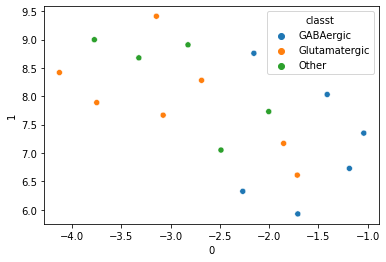

In [657]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = features.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

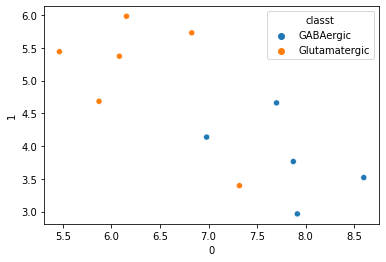

In [543]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

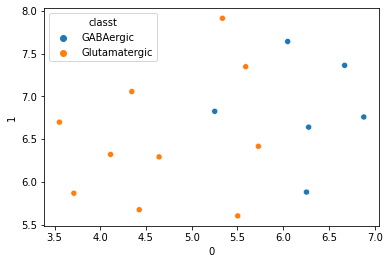

In [565]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<Axes: xlabel='0', ylabel='1'>

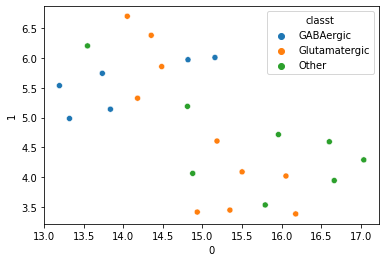

In [568]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = dk.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

<ipython-input-676-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


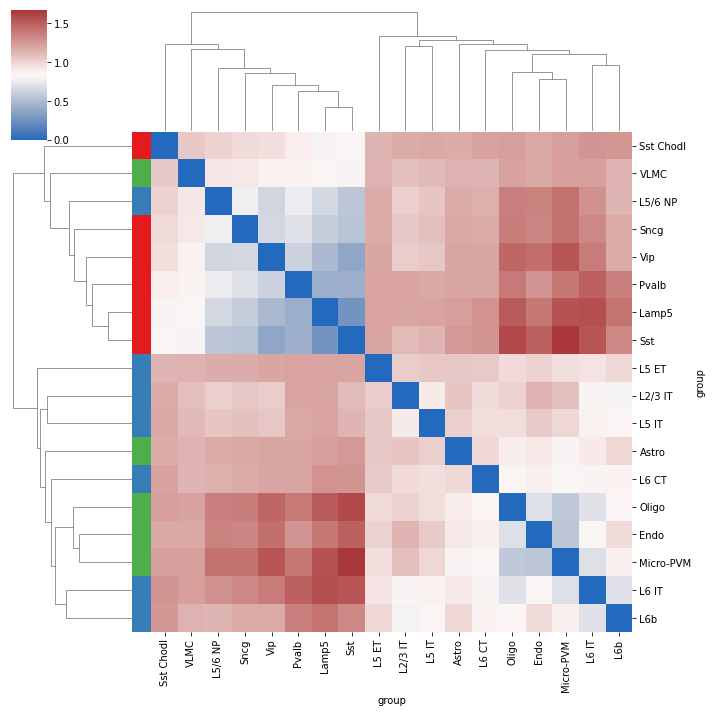

In [676]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-655-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


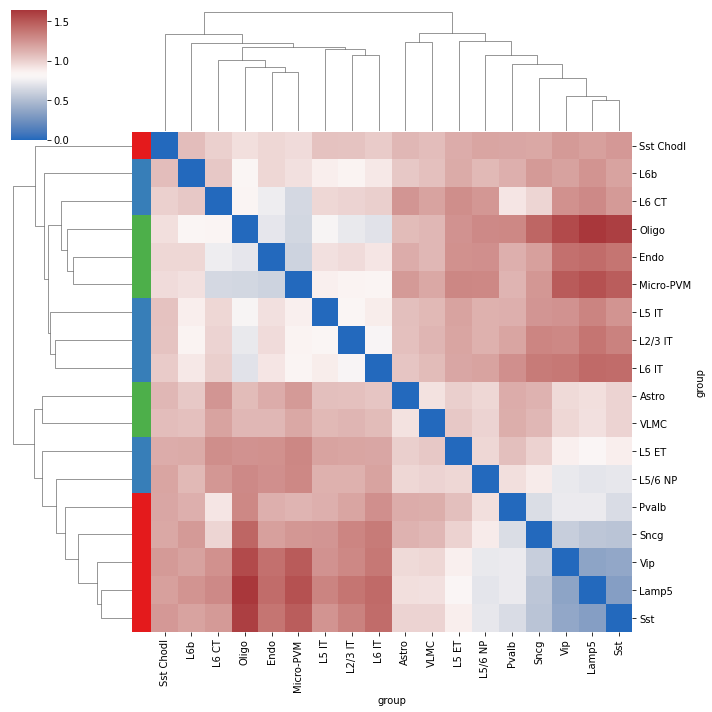

In [655]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-691-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


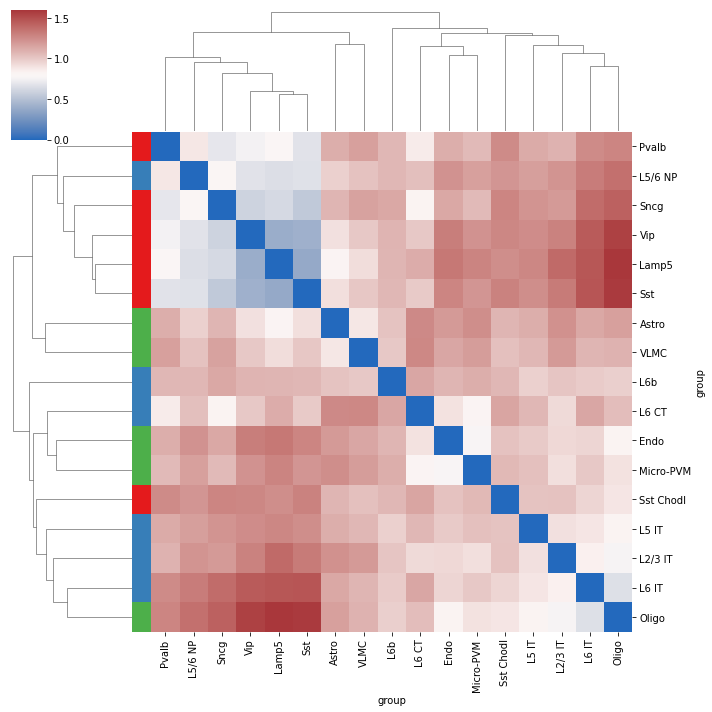

In [691]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-636-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


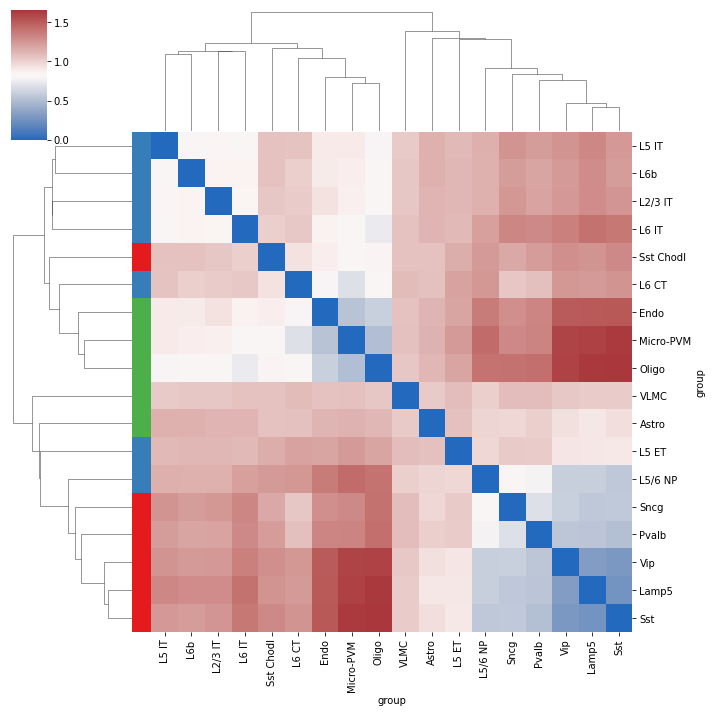

In [636]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [648]:
j

NameError: name 'j' is not defined

In [645]:
jk

NameError: name 'jk' is not defined

<ipython-input-644-595277841f4e>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


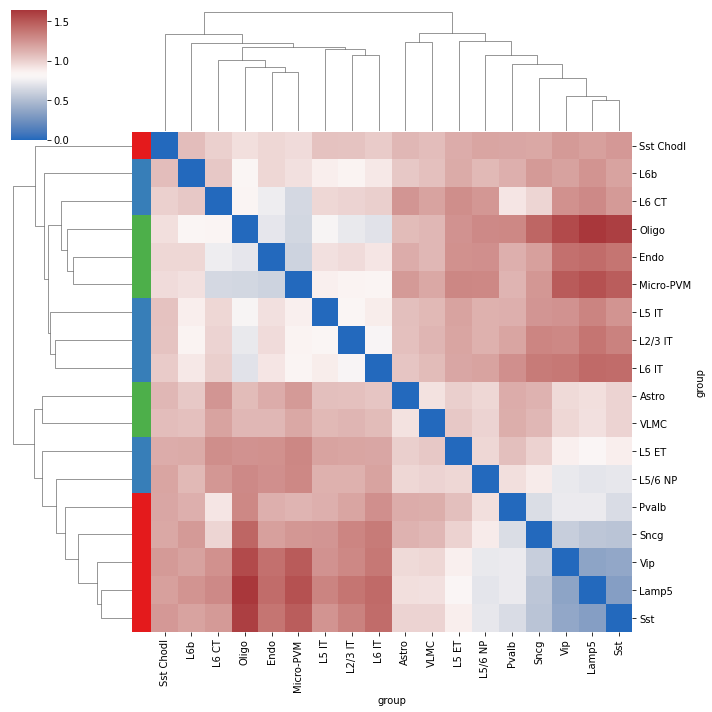

In [644]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otheer']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [613]:
a

NameError: name 'a' is not defined

In [720]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        #marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_cluster_markers.csv.gz', skiprows=1)
        marker_list_t = pd.read_csv(f'{base_folder}//hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

        marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

        marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)
        
        
        
        marker_list = marker_list[['gene', 'group', 'cell_type', 'recurrence', 'n_datasets', 'rank', 'auroc']].merge(marker_list_t[['classt', 'group']], how='left')
        
        marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
        
        
        
        cluster_groups = marker_list['group'].drop_duplicates().tolist()
        
        
        marker_list_tmp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')
        
        marker_list_tmp2 = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/mouse/joint_subclass_markers.csv.gz', skiprows=1)
        
        
        marker_list_tmp = pd.concat([marker_list_tmp2, marker_list_tmp])
        
        
        marker_list_tmp.rename(columns = {'group':'classt'}, inplace = True)
        marker_list_tmp.rename(columns = {'cell_type':'group'}, inplace = True)
        marker_list_tmp['cell_type'] = marker_list_tmp['group'].tolist()
        
        
        #marker_list = pd.concat([marker_list, marker_list_tmp[~marker_list_tmp['group'].isin(cluster_groups)]])
        marker_list = pd.concat([marker_list, marker_list_tmp])
        
        #bakken_groups = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv')['subclass_Bakken_2022'].drop_duplicates().tolist()
        
        
        
        #marker_list = marker_list[marker_list['group'].isin(bakken_groups)]
        print (marker_list)
        
        
        marker_list['%recurrence'] = marker_list['recurrence'] / marker_list['n_datasets']
        
        #marker_list_temp = pd.read_csv(f'{base_folder}/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        #marker_list_temp['group'] = marker_list_temp['cell_type']
        #marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv(f'{base_folder}/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        marker_list = marker_list.sort_values(by=['rank', '%recurrence', 'auroc']).drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        
        print (all_cell_types)
        df2_list = []



        for group2 in all_cell_types:
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            m_tmp = marker_list[marker_list['cell_type']==group2]
            #df2_list.append(m_tmp[m_tmp['rank'].isin(list(all_marker_2))])
            #df2_list.append(m_tmp[m_tmp['rank'] < 100])
            df2_list.append(m_tmp[m_tmp['recurrence'] >=1])
            
            #df2_list.append(m_tmp[m_tmp['%recurrence'] >0.80])
            #df2_list.append(m_tmp)
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        #marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


                gene    group  cell_type  recurrence  n_datasets  rank  \
0      6530403H02Rik  L2/3 IT  L2/3 IT_1           5           6     1   
1            Adamts2  L2/3 IT  L2/3 IT_1           5           6     2   
2            Col23a1  L2/3 IT  L2/3 IT_1           5           6     3   
3                Met  L2/3 IT  L2/3 IT_1           5           6     4   
4                Ust  L2/3 IT  L2/3 IT_1           5           6     5   
...              ...      ...        ...         ...         ...   ...   
12995        Ube2ql1      L6b        L6b           0           7   996   
12996      Gabarapl2      L6b        L6b           0           7   997   
12997           Myh3      L6b        L6b           0           7   998   
12998      Hnrnpa2b1      L6b        L6b           0           7   999   
12999         Psmd14      L6b        L6b           0           7  1000   

          auroc         classt  fold_change  fold_change_detection  ...  \
0      0.842734  Glutamatergic      

In [721]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [722]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]


#df_gene_tp = df_gene_tp.fillna(0)

In [723]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

In [724]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group', 'cell_type']).mean()

In [725]:
blacklist_bins = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_bin_blacklist_10kb.bed', sep='\t', names=['d', 'd1', 'd2', 'bin_id', 'c', 'c1', 'c2', 'c3', 'c4'])


In [727]:
pure_bins = list(set(df_gene_tp_all_info_mean.columns.tolist()) - set(blacklist_bins['bin_id'].tolist()))

In [728]:
dl = df_gene_tp_all_info_mean
dl = dl.reset_index()
dj = dl[dl['classt']!='Otheer']
dk = dj.groupby(['group']).mean()
features = dk.loc[:, pure_bins]
#features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)

In [731]:
df_all_peak = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_atac_peak_10kb.bed', sep='\t', names=['chrd', 'bin_st', 'bin_end', 'bin_id', 'chr', 'start', 'end', 'peak', 'overlap'])


df_all_peak = df_all_peak[df_all_peak['overlap'] >= 250]


features_sc_df = pd.DataFrame(features_sc.T,  index=features.T.index, columns = features.T.columns)


In [732]:
given_group='L5 ET'

In [734]:
dj = features.T[given_group].reset_index()

dj['spec'] = features_sc_df[given_group].tolist()

dj = dj.merge(df_all_peak, left_on='index', right_on='bin_id').sort_values(by=['spec', 'L5 ET', 'overlap'], ascending=False).drop_duplicates('peak')


#dj = dj.sort_values(by=['spec', given_group], ascending=False)


dj['rank'] = list(range(1,dj.shape[0]+1))

In [735]:
dj[dj['peak'].isin(['chr1:38828697-38829197'])]

index     L5 ET      spec  chrd    bin_st   bin_end  bin_id   chr  \
5200   3882  0.432907 -0.660841  chr1  38820000  38830000    3882  chr1   

         start       end                    peak  overlap    rank  
5200  38828697  38829197  chr1:38828697-38829197      500  397932

<ipython-input-708-f163ab77a7eb>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


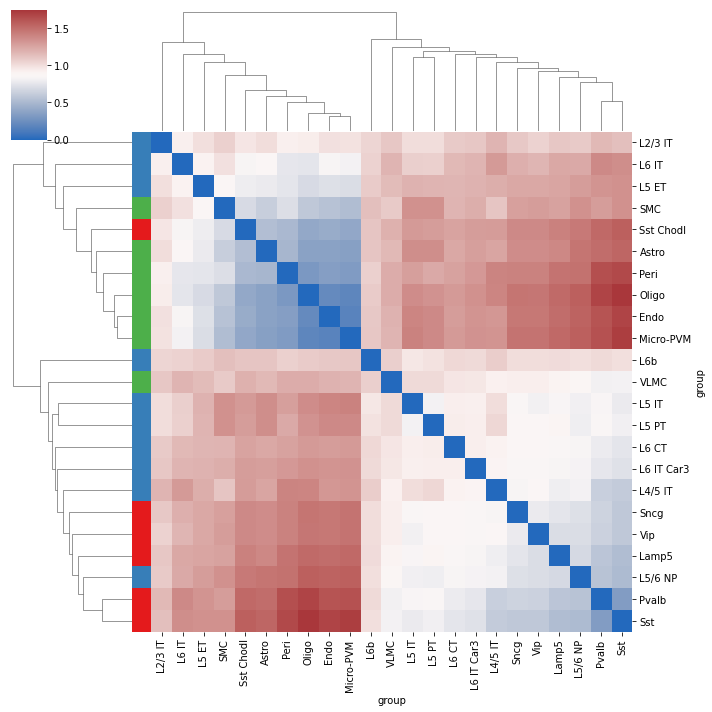

In [708]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otherk']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



<ipython-input-714-f163ab77a7eb>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


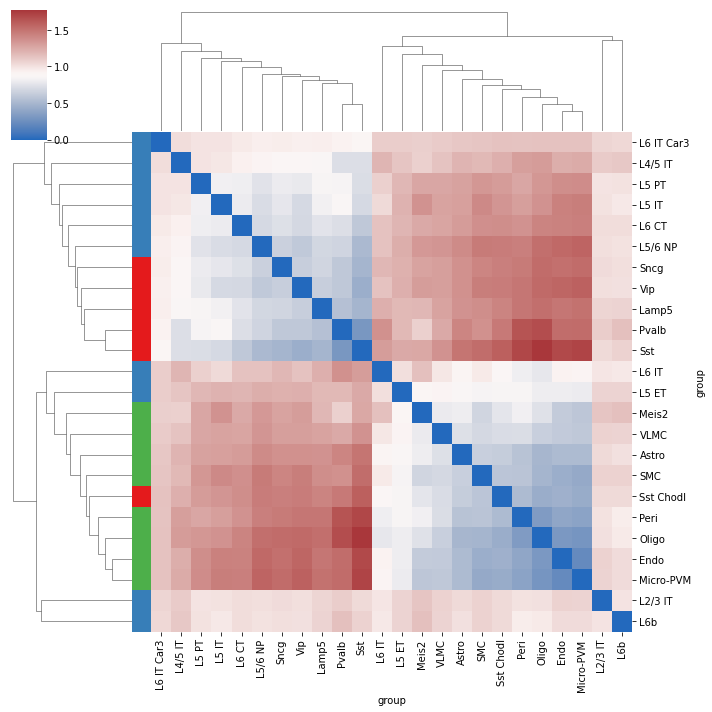

In [714]:
dj = df_gene_tp_all_info_mean
dj = dj.reset_index()
dj = dj[dj['classt']!='Otherk']
dk = dj.groupby(['classt','group']).mean()
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [715]:
dl = df_gene_tp_all_info_mean
dl = dl.reset_index()
dj = dl[dl['classt']!='Otheer']
dk = dj.groupby(['group']).mean()
features = dk.loc[:, pure_bins]
#features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)

NameError: name 'pure_bins' is not defined

In [ ]:
df_all_peak = pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_atac_peak_10kb.bed', sep='\t', names=['chrd', 'bin_st', 'bin_end', 'bin_id', 'chr', 'start', 'end', 'peak', 'overlap'])


df_all_peak = df_all_peak[df_all_peak['overlap'] >= 250]


features_sc_df = pd.DataFrame(features_sc.T,  index=features.T.index, columns = features.T.columns)



In [ ]:
given_group='L5 ET'

<ipython-input-347-1eb310eb292a>:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


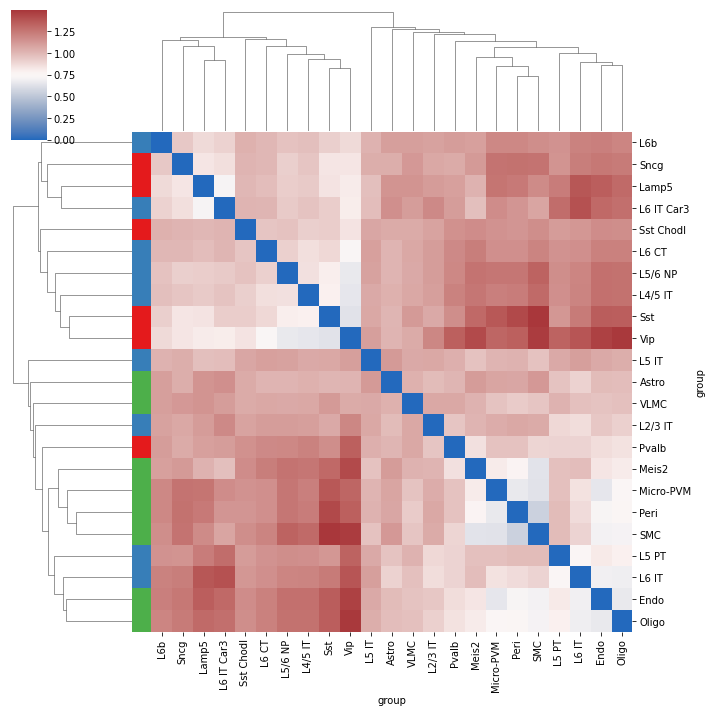

In [347]:
#dj = pd.concat(marker_mean_list)
#dj = dj.reset_index()
#dj = dj[dj['classt']=='GABAergic']
dk = df_gene_tp_all_info_mean.loc[:, :]
lut = dict(zip( dk.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", dk.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =dk.index.get_level_values('classt').map(lut)



features = dk.loc[:, :]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)



In [ ]:
os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -wao -b {base_folder}/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a {base_folder}/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  {base_folder}/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    

In [499]:
pd.read_csv('/grid/gillis/data_norepl/lohia/BICCN_enhancer_challenege/10XMultiome/Mouse/all_final.csv').drop_duplicates(['subclass_Bakken_2022']).tolist()

chr      start        end subclass_Bakken_2022   rank
0       chr10   73099614   73100114            Sst Chodl      1
1        chr9   29654837   29655337            Sst Chodl      2
2       chr14  117958281  117958781            Sst Chodl      3
3       chr11   81969674   81970174            Sst Chodl      4
4       chr16   39985210   39985710            Sst Chodl      5
...       ...        ...        ...                  ...    ...
189995   chr2   38249647   38250147                 VLMC   9996
189996  chr17    4486808    4487308                 VLMC   9997
189997   chr2   70211458   70211958                 VLMC   9998
189998   chr8   16986866   16987366                 VLMC   9999
189999   chr3  118510827  118511327                 VLMC  10000

[190000 rows x 5 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

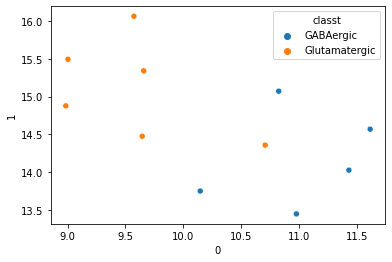

In [23]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [289]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

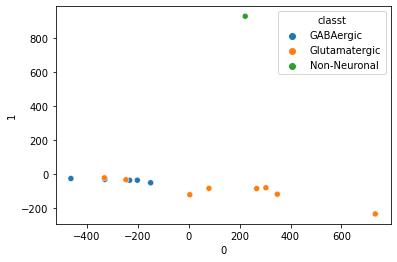

In [290]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [251]:
dj = pd.concat([df_gene_tp_all_info_mean_group1, df_gene_tp_all_info_mean_group2])

dj = dj.reset_index()

dj = dj[dj['classt']=='GABAergic']



from sklearn.decomposition import PCA
features = dj.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
pca = PCA(n_components=3)
proj_2da = pca.fit_transform(features_sc)
df_proj_2da= pd.DataFrame(proj_2da)
df_proj_2da['classt'] = dj['classt'].tolist()
df_proj_2da['group'] = dj['group'].tolist()



In [702]:
dj

classt      group      cell_type         0         1         2  \
0   GABAergic      Lamp5  Lamp5 Egln3_1 -1.141074 -1.141074 -1.141074   
1   GABAergic      Lamp5  Lamp5 Egln3_2 -1.105237 -1.105237 -1.105237   
2   GABAergic      Lamp5  Lamp5 Egln3_3 -1.143988 -1.143988 -1.143988   
3   GABAergic      Lamp5     Lamp5 Lhx6 -1.131675 -1.131675 -1.131675   
4   GABAergic      Lamp5     Lamp5 Pax6 -1.213241 -1.213241 -1.213241   
..        ...        ...            ...       ...       ...       ...   
81      Other      Astro          Astro -1.178825 -1.178825 -1.178825   
82      Other       Endo           Endo -1.157111 -1.157111 -1.157111   
83      Other  Micro-PVM      Micro-PVM -1.142855 -1.142855 -1.142855   
84      Other      Oligo          Oligo -1.217294 -1.217294 -1.217294   
85      Other       VLMC           VLMC -1.190058 -1.190058 -1.190058   

           3         4         5         6  ...    246275    246276    246277  \
0  -1.141074 -1.141074 -1.141074 -1.141074  ... -1.158844 -1.158844 -1.158844   
1  -1.105237 -1.105237 -1.105237 -1.105237  ... -1.107228 -1.107228 -1.107228   
2  -1.143988 -1.143988 -1.143988 -1.143988  ... -1.157407 -1.157407 -1.157407   
3  -1.131675 -1.131675 -1.131675 -1.131675  ... -1.142061 -1.142061 -1.142061   
4  -1.213241 -1.213241 -1.213241 -1.213241  ... -1.196680 -1.196680 -1.196680   
..       ...       ...       ...       ...  ...       ...       ...       ...   
81 -1.178825 -1.178825 -1.178825 -1.178825  ... -1.180437 -1.180437 -1.180437   
82 -1.157111 -1.157111 -1.157111 -1.157111  ... -1.164132 -1.164132 -1.164132   
83 -1.142855 -1.142855 -1.142855 -1.142855  ... -1.154068 -1.154068 -1.154068   
84 -1.217294 -1.217294 -1.217294 -1.217294  ... -1.226504 -1.226504 -1.226504   
85 -1.190058 -1.190058 -1.190058 -1.190058  ... -1.198093 -1.198093 -1.198093   

      246278    246279    246280    246281    246282    246283    246284  
0  -1.158844 -1.158844 -1.158844 -1.158844 -1.158844 -1.158844 -1.158844  
1  -1.107228 -1.107228 -1.107228 -1.107228 -1.107228 -1.107228 -1.107228  
2  -1.157407 -1.157407 -1.157407 -1.157407 -1.157407 -1.157407 -1.157407  
3  -1.142061 -1.142061 -1.142061 -1.142061 -1.142061 -1.142061 -1.142061  
4  -1.196680 -1.196680 -1.196680 -1.196680 -1.196680 -1.196680 -1.196680  
..       ...       ...       ...       ...       ...       ...       ...  
81 -1.180437 -1.180437 -1.180437 -1.180437 -1.180437 -1.180437 -1.180437  
82 -1.164132 -1.164132 -1.164132 -1.164132 -1.164132 -1.164132 -1.164132  
83 -1.154068 -1.154068 -1.154068 -1.154068 -1.154068 -1.154068 -1.154068  
84 -1.226504 -1.226504 -1.226504 -1.226504 -1.226504 -1.226504 -1.226504  
85 -1.198093 -1.198093 -1.198093 -1.198093 -1.198093 -1.198093 -1.198093  

[86 rows x 246288 columns]

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


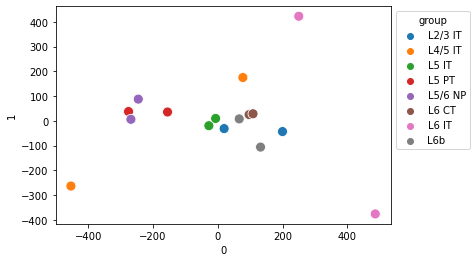

In [250]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


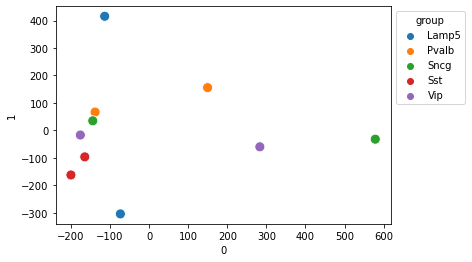

In [252]:
ax= sns.scatterplot(
    df_proj_2da[0], df_proj_2da[1],
    hue=df_proj_2da['group'],s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

<ipython-input-159-9c5bde4097ba>:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


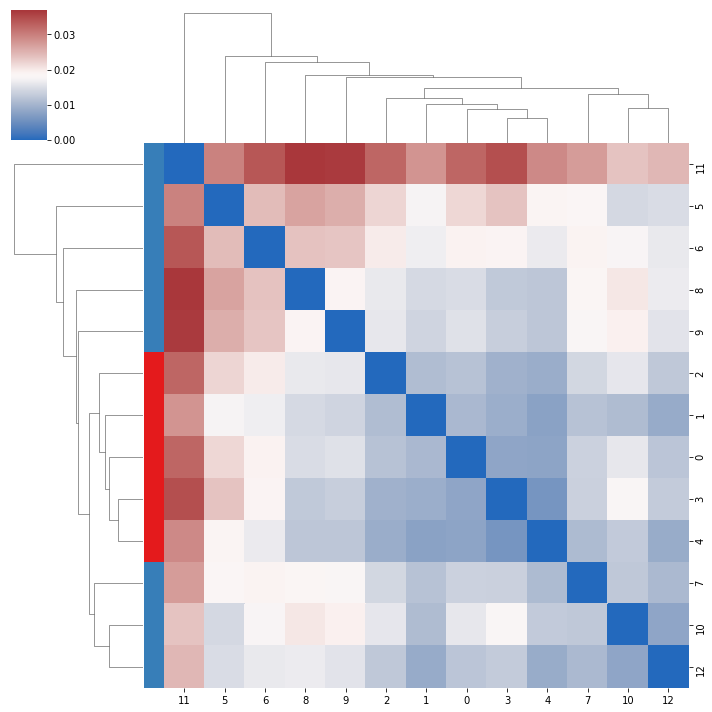

In [159]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >=0].index.tolist()]
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


<ipython-input-188-33ff0a366977>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


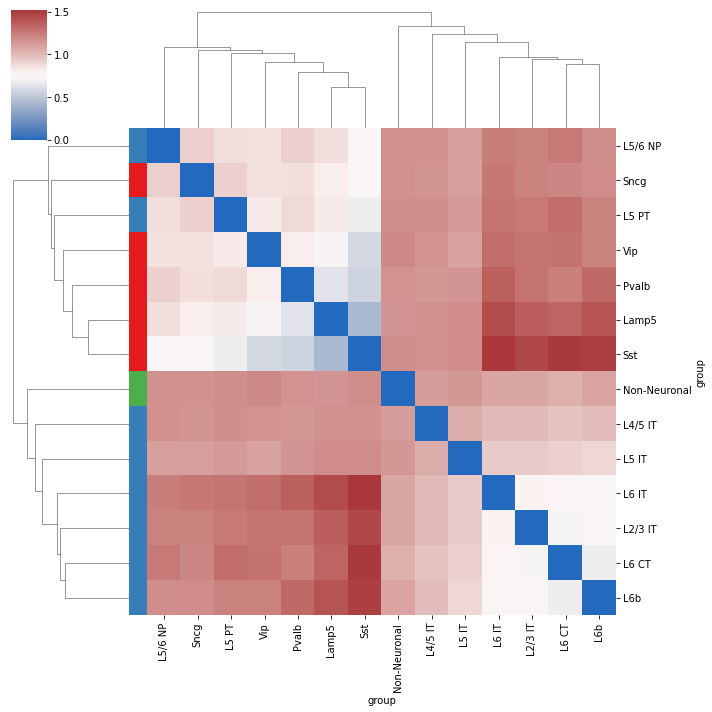

In [188]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


In [185]:
df_dist.shape

(13, 13)

In [183]:
features.index.get_level_values('group')

Index(['Lamp5', 'Pvalb', 'Sncg', 'Sst', 'Vip', 'L2/3 IT', 'L4/5 IT', 'L5 IT',
       'L5 PT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6b', 'Non-Neuronal'],
      dtype='object', name='group')

In [161]:
all_bins_mean.median()

-0.010484438389539719

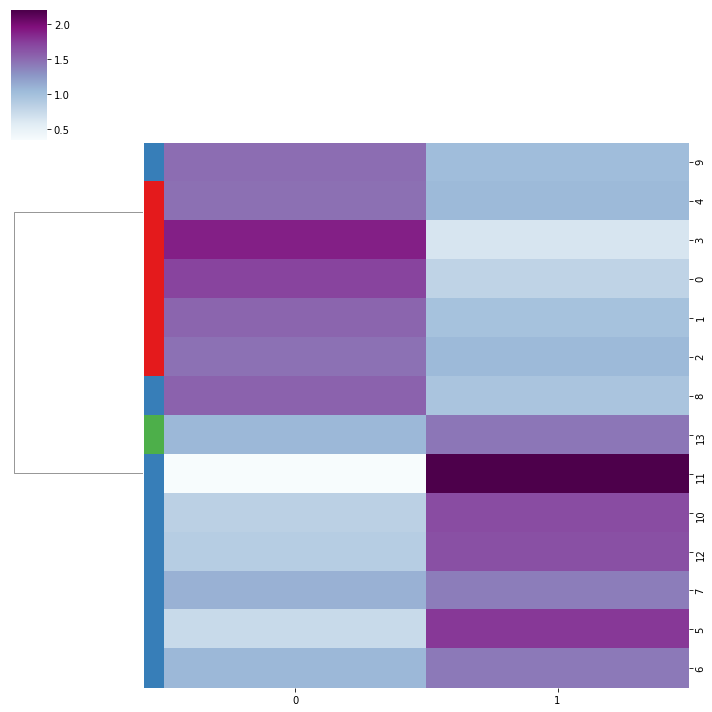

In [148]:
from sklearn.decomposition import NMF



features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
features_sc = abs(features_sc.min()) + features_sc

model = NMF(n_components=2, init='random', random_state=2)
W = model.fit_transform(features_sc)
H = model.components_
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors,  metric="correlation")



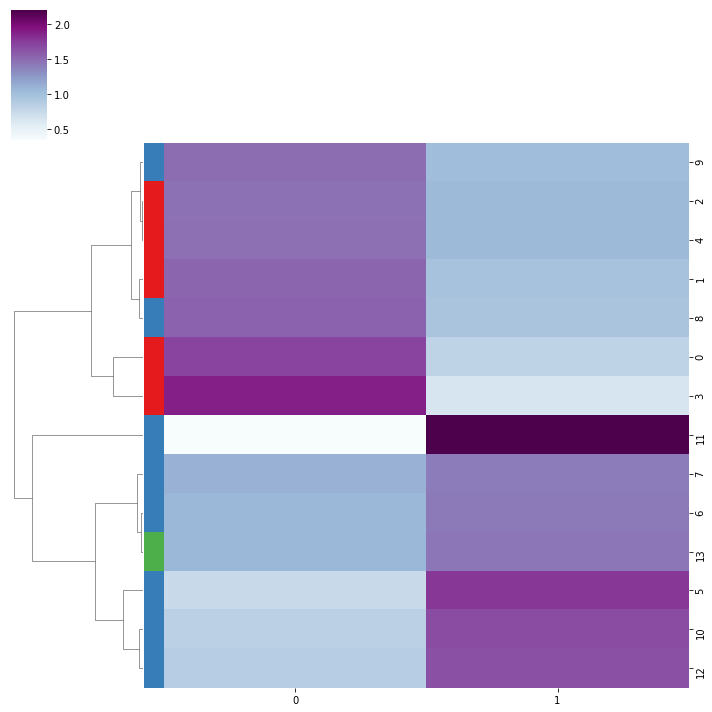

In [149]:
sns.clustermap(W, cmap="BuPu", col_cluster=False, robust=False, row_colors=row_colors)


<ipython-input-118-ada1e006cb4e>:11: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist[[np.arange(df_dist.shape[0])]*2] = 0


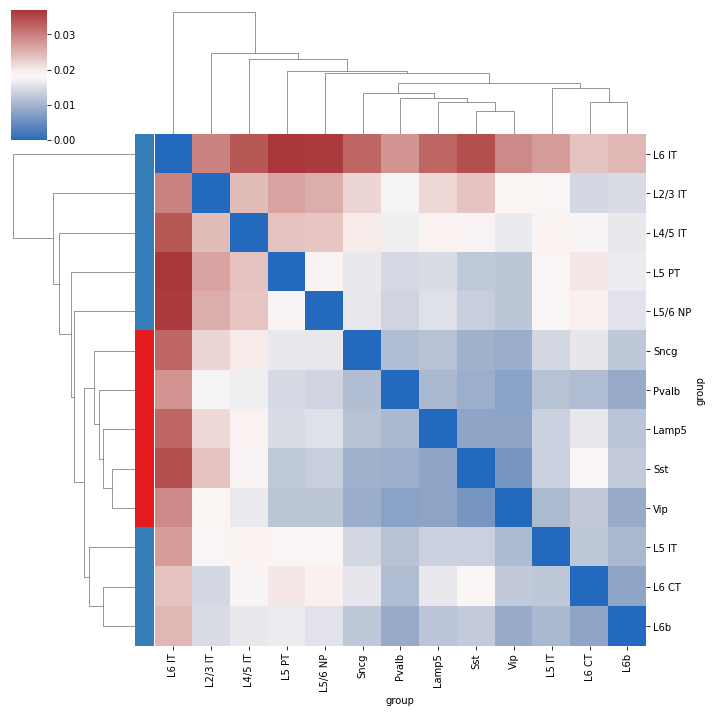

In [118]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >=0].index.tolist()]
features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
df_dist_df = pd.DataFrame(df_dist,  index=features.index.get_level_values('group'), columns = features.index.get_level_values('group'))

sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors)


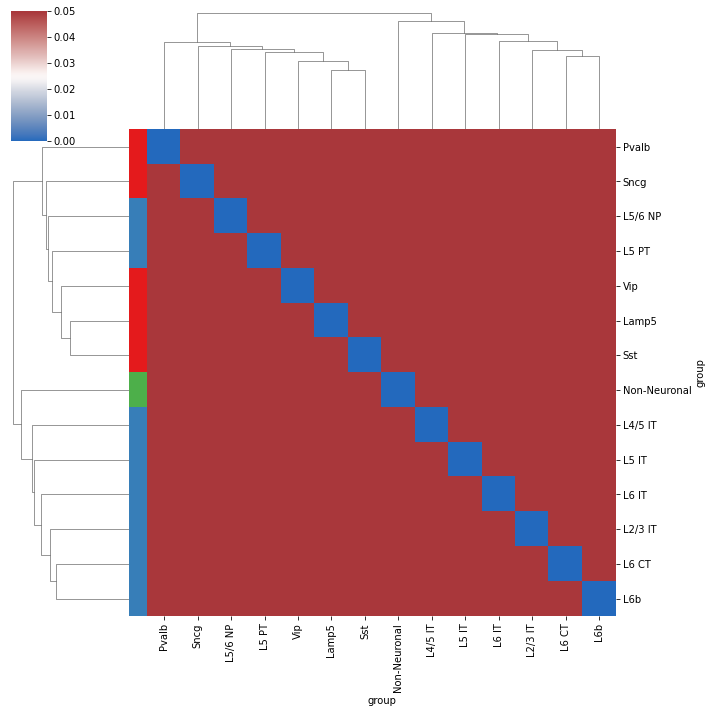

In [145]:
sns.clustermap(df_dist_df, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors, vmax=0.05)


In [119]:
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)
R1 = np.round(np.corrcoef(features_sc), 10)
R1 = R1 + abs(R1.min())
df_dist_df = pd.DataFrame(R1 ,  index=df_gene_tp_all_info_mean.index.get_level_values('group'), columns = df_gene_tp_all_info_mean.index.get_level_values('group'))


In [120]:
df_go = df_gene_tp_all_info_mean[[0]].reset_index()

df_go['val'] = 1

df_go_table = df_go.pivot_table(index='group', columns='classt', values='val', aggfunc='sum')
df_go_table.fillna(0, inplace=True)

(13, 13)
(13, 2)
0.5
0.011834319526627168


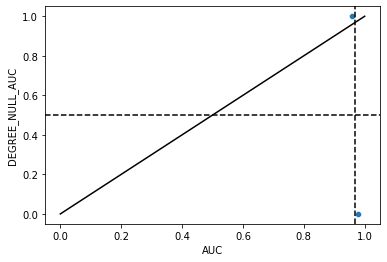

In [121]:

        df_2d_jac, go_chrom  = run_egad(df_go_table, df_dist_df )
        %matplotlib inline
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.scatterplot(data=df_2d_jac, x='AUC', y='DEGREE_NULL_AUC')
        plt.plot([0, 1], [0, 1], c='black')
        plt.axvline(x=df_2d_jac['AUC'].mean(),c='black',ls='--')
        plt.axhline(y=df_2d_jac['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [122]:
df_2d_jac

AUC  AVG_NODE_DEGREE  DEGREE_NULL_AUC   P_Value
classt                                                             
GABAergic      0.958333         6.882918              1.0  0.001025
Glutamatergic  0.977778         6.131162              0.0  0.000209